C:\Users\sofia\AppData\Local\Temp\ipykernel_9780\3015042532.py:19: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  data = pd.read_html(str(tables[0]))[0]


Выберите год:


 2020


Дата начала половодья 24-03-2020, дата окончания половодья 12-06-2020
Расход воды в начале половодья 256.0 м³/с, расход воды по окончанию половодья 266.0 м³/с


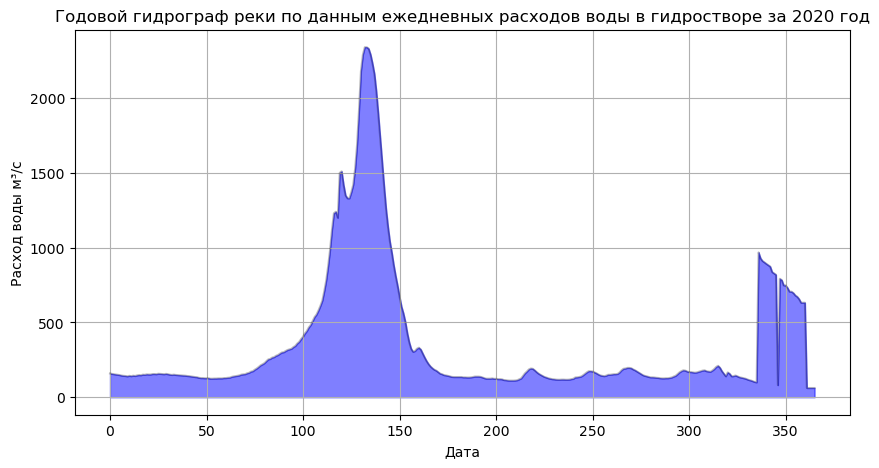

In [13]:
import pandas as pd
import statistics as st
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import datetime as datetime

# считаем исходный файл
xls_file = 'river.xls'
with open(xls_file, 'r', encoding='utf-8') as file:
    html_type = file.read()

# предполагаемо, данный xls файл был написан с помощью разметки html и после криво переделан в xls. Считаем файл по правилам html
html = BeautifulSoup(html_type, 'html.parser')

# найдем таблицы в html файле
tables = html.find_all('table')

# считаем ее и запишем в сохраним как файл в формате .txt
data = pd.read_html(str(tables[0]))[0]
txt_file = xls_file.replace('.xls', '.txt')
data.to_csv(txt_file, sep='\t', index=False)

# считаем построчно свежесозданный файл
with open('river.txt', encoding='utf-8') as a:
    g = a.readlines()

# запросим с клавиатуры ввод необзодимого года и найдем номер строки, в которой он находится 
print('Выберите год:')
y = int(input())
i = 6
while i < len(g):
    year = int(g[i][4:8])
    if year == y:
        break
    i = i + 47
ln = i #ln - номер строки с нужным нам годом
i = 0

# запишем словарь, где ключ - номер месяца, значение - количество дней 
month = {'1': 31,
        '2': 28,
        '3': 31,
        '4': 30,
        '5': 31,
        '6': 30,
        '7': 31,
        '8': 31,
        '9': 30,
        '10': 31,
        '11': 30,
        '12': 31}
# проверим, високосный ли год
if (year % 4 == 0 and year % 100 != 0) or year % 400 == 0:
    month['2'] = 29

# создадим список dates_365 с датами в формате от 1 до 365,
# создадим двумерный массив dates с датами в виде списка [1, 21], где первый элемент номер месяца, а второй число
# и создадим список flow с расходом, предварительно заполнив его нулями (длина списка = длине dates_365)
dates_365 = [] 
dates = []
flow = []
d = 0
for i in range(12):
    m = 0
    for j in range(month[str(i+1)]):
        m = m + 1
        d = d + 1
        dates.append([i+1, m])
        dates_365.append(d)
        flow.append(0) 


ln1 = ln
for i in range(len(dates)): #пройдемся по датам в формате месяц, число
    line = g[ln1+dates[i][1]+3].split() #разделим строку с нужными числам месяца на элементы
    j = 1
    d = 1
    while j < len(line): # мы начинаем отсчет со второго элемента, так как первый - всегда номер месяца
        if line[j] == '^' or line[j] == '_' or line[j] == 'ю' or line[j] == 'ю^' or line[j] == 'ю_' or line[j] == '^ю': # побочные данные нам не нужны, поэтому встретим их, переходим к следующему элементу списка
            j = j + 1
            continue
        else:
            if int(d) == int(dates[i][0]): # найдя нужный месяц для числа записываем его в список flow, предварительно заменив , на .
                tmpr = line[j] 
                if ',' in tmpr:
                    indx = tmpr.find(',')
                    tmpr = tmpr[0:indx]+'.'+tmpr[indx+1:len(tmpr)]
                flow[i] = float(tmpr)
                break
            else: 
                d = d + 1
                j = j + 1

# flow - данные о потоке
# dates_365 - даты в формате от 1 до 365
# dates - даты в формате [[1, 12], [1, 13]....], где первое - номер месяца, второе - число

# найдем день с максимальным расходом - flow_max_date
flow_max_date = flow.index(max(flow)) + 1

# найдем даты начала и окончания половодья
# будем считать, что данные даты соответствуют разнице между среднем арифметическим и среднемедианным расходом для рек средней полосы с одним половодьем

# avg - среднее арифметическое
# avg_mdn - среднее медианное 
avg = st.mean(flow)
avg_mdn = st.median(flow)

# найдем примерный расход в предполагаемые даты начала и конца половодья 
plvd = (avg+avg_mdn)/2
# найдем ближайшие элементы в списке до и после пика половодья - его начало (start) и конец (fin)
start = min(flow[0:flow.index(max(flow))], key=lambda x: abs(x - plvd))
fin = min(flow[flow.index(max(flow)):-1], key=lambda x: abs(x - plvd))

# найдем даты начали и конца половодья - start_date и fin_date соответственно 
start_date = flow.index(start) + 1
fin_date = flow.index(fin) + 1

# Переведем номер дня в году в формат ДД-ММ-ГГ
start_date_format = (datetime.datetime(int(y), 1, 1) + datetime.timedelta(int(start_date) - 1)).strftime('%d-%m-%Y') 
fin_date_format = (datetime.datetime(int(y), 1, 1) + datetime.timedelta(int(fin_date) - 1)).strftime('%d-%m-%Y')

print(f'Дата начала половодья {start_date_format}, дата окончания половодья {fin_date_format}')
print(f'Расход воды в начале половодья {start} м\u00B3/с, расход воды по окончанию половодья {fin} м\u00B3/с')

plt.figure(figsize=(10,5)) # Зададим размер холста
plt.scatter(range(len(flow)), flow, color='black', alpha=0, label='Data points') # Нарисуем точки с координатами из x по горизонтальной оси и из y по вертикальной оси
plt.plot(range(len(flow)), flow, color='black', alpha=0.25, linestyle='-', label='Connecting line') # Соединим точки линией
plt.fill_between(range(len(flow)), flow, color='blue', alpha=0.5) # Закрасим пространство под линией
plt.title(f'Годовой гидрограф реки по данным ежедневных расходов воды в гидростворе за {y} год') # Зададим заголовок графика
plt.xlabel('Дата') # Зададим название оси Ох
plt.ylabel('Расход воды м\u00B3/с') # Зададим название оси Оу
plt.grid(True) # Добавим сетку на график
plt.show() # Отобразим график

## 